# Part 2: "The Intern" (Fine-Tuning) - Refined Edition

**Objective:** Fine-tune a Llama-3-8B model on the financial dataset to learn the strategy and tone of the 2024 Annual Report.

**Key Features:**
- **Reproducibility:** Strict random seed setting.
- **Visualization:** Training loss plots and Base vs. Tuned comparisons.
- **Extended Evaluation:** Testing on `golden_test_set.jsonl` and saving results.
- **Optimization:** 4-bit quantization and LoRA optimization.

## 1. Setup & Dependencies

**IMPORTANT:** If you see an error like `AttributeError: partially initialized module 'torchvision'` or `ModuleNotFoundError: PreTrainedModel`, you **MUST**:
1. Run the cell below.
2. **Restart the Runtime** (Runtime -> Restart session).
3. Run the valid imports cell (skip the install cell if you just ran it).

In [1]:
# 1. Uninstall potentially conflicting versions first
!pip uninstall -y torchvision torch torchaudio

# 2. Install compatible Torch + Torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# 3. Install other dependencies (including python-dotenv for local env)
!pip install -q -U transformers peft trl bitsandbytes accelerate datasets scipy matplotlib python-dotenv

print("Installation complete. PLEASE RESTART RUNTIME now if this is the first run.")

Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (3.4 MB)
Installation complete. PLEASE RESTART RUNTIME now if this is the first run.


In [2]:
import torch
import os
import random
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
import matplotlib.pyplot as plt

# Environment Check
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
Device: Tesla T4
VRAM: 14.56 GB


## 2. strict Reproducibility (Seeds)

In [3]:
SEED = 42

# Set environment variable for Python hash seed
os.environ['PYTHONHASHSEED'] = str(SEED)

# Set seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Note: These settings may impact performance
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f" Seeds set to {SEED} for reproducibility")
print(" Note: Full determinism on GPU is not guaranteed due to non-deterministic operations")

 Seeds set to 42 for reproducibility
 Note: Full determinism on GPU is not guaranteed due to non-deterministic operations


## 3. Path Configuration & Storage

In [4]:
import os
import sys

# 1. Define the User's Local Path
USER_LOCAL_ROOT = r"C:/Development/financial-intelligence-engine"
USER_LOCAL_DATA = os.path.join(USER_LOCAL_ROOT, "data/processed")
USER_LOCAL_OUTPUT = os.path.join(USER_LOCAL_ROOT, "data/results")

# 2. Check Environment
if os.path.exists(USER_LOCAL_ROOT):
    # Running Locally (Windows/VS Code Local Kernel)
    print(" Local Windows Environment Detected.")
    BASE_PATH = USER_LOCAL_ROOT
    DATA_PATH = USER_LOCAL_DATA
    OUTPUT_PATH = USER_LOCAL_OUTPUT

elif 'google.colab' in sys.modules:
    # Running in Colab
    print(" Google Colab Environment Detected.")
    from google.colab import drive
    drive.mount('/content/drive')

    # Define Drive Structure
    DRIVE_ROOT = "/content/drive/MyDrive/Financial_Intern_Project"

    # Create directories if they don't exist
    os.makedirs(DRIVE_ROOT, exist_ok=True)
    os.makedirs(f"{DRIVE_ROOT}/data", exist_ok=True)
    os.makedirs(f"{DRIVE_ROOT}/results", exist_ok=True)

    BASE_PATH = DRIVE_ROOT
    DATA_PATH = f"{DRIVE_ROOT}/data/processed"
    OUTPUT_PATH = f"{DRIVE_ROOT}/results"

    print(f" Google Drive Mounted at: {BASE_PATH}")
    print(f" Please upload 'train.jsonl' to: {DATA_PATH}")
    print(f"Results will be saved to: {OUTPUT_PATH}")

elif os.path.exists("/mnt/c"):
    # WSL
    print(" WSL Detected.")
    BASE_PATH = "/mnt/c/Development/financial-intelligence-engine"
    DATA_PATH = f"{BASE_PATH}/data/processed"
    OUTPUT_PATH = f"{BASE_PATH}/data/results"
else:
    # Generic Local / Repo Root
    print("Generic Environment. Using relative paths.")
    BASE_PATH = "."
    DATA_PATH = "../data/processed"
    OUTPUT_PATH = "../data/results"

print(f" Data Path: {DATA_PATH}")
print(f" Output Path: {OUTPUT_PATH}")

 Google Colab Environment Detected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive Mounted at: /content/drive/MyDrive/Financial_Intern_Project
 Please upload 'train.jsonl' to: /content/drive/MyDrive/Financial_Intern_Project/data/processed
Results will be saved to: /content/drive/MyDrive/Financial_Intern_Project/results
 Data Path: /content/drive/MyDrive/Financial_Intern_Project/data/processed
 Output Path: /content/drive/MyDrive/Financial_Intern_Project/results


## 4. Configuration

In [5]:
CONFIG = {
    # Model
    # "model_id": "meta-llama/Meta-Llama-3-8B-Instruct",
    "model_id": "unsloth/Meta-Llama-3.1-8B-Instruct",
    "new_model_name": "Llama-3-8b-Financial-Intern",
    "hf_username": "p-sahas",

    # LoRA
    "lora_r": 64,
    "lora_alpha": 16,
    "lora_dropout": 0.1,
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],

    # Training
    "batch_size": 1,
    "grad_accumulation": 4,
    "learning_rate": 2e-4,
    "num_epochs": 1,
    "max_steps": 150,
    "logging_steps": 10,
    "save_steps": 50,
    "max_seq_length": 512,
    "output_dir": OUTPUT_PATH, # Uses dynamic path
}

## 5. Hugging Face Login

In [6]:
from huggingface_hub import login
import os

# Attempt to load .env file if available (local usage)
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    print("python-dotenv not installed, skipping .env loading (pip install python-dotenv)")

try:
    # 1. Try Environment Variable (from .env or system)
    token = os.getenv("HF_TOKEN")

    # 2. If missing, Try Colab Secrets
    if not token:
        try:
            from google.colab import userdata
            token = userdata.get('HF_TOKEN')
        except ImportError:
            pass # Not in Colab
        except Exception as e:
            print(f"Colab secret fetch skipped: {e}")

    # 3. Login or Fallback
    if token:
        print(f"Logging in with token: {token[:4]}...{token[-4:]}")
        login(token)
    else:
        raise ValueError("HF_TOKEN not found in environment variable or Colab secrets.")

except Exception as e:
    # Fallback to interactive login
    print(f"Automatic login failed: {e}")
    print("Falling back to manual login...")
    login()

Colab secret fetch skipped: Secret HF_TOKEN does not exist.
Automatic login failed: HF_TOKEN not found in environment variable or Colab secrets.
Falling back to manual login...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 6. Data Loading & Formatting

In [7]:
import json
import os
from datasets import load_dataset

# Use the dynamic DATA_PATH configured earlier
dataset_filename = "train.jsonl"
possible_paths = [
    r"c:/Development/financial-intelligence-engine/data/processed/train.jsonl", # Absolute path (Highest Priority)
    os.path.join(DATA_PATH, dataset_filename),  # Path from Config (Local/Drive)
    "train.jsonl",                              # Copy in CWD
    "../data/processed/train.jsonl",            # Relative fallback
    "/content/train.jsonl"                      # Colab root
]

dataset_path = None
for path in possible_paths:
    if os.path.exists(path):
        dataset_path = path
        break

if not dataset_path:
    print(f" Dataset not found in known locations. Searched: {possible_paths}")
    raise FileNotFoundError("CRITICAL: Dataset 'train.jsonl' not found. Cannot proceed.")

print(f"Using dataset path: {dataset_path}")
try:
    train_dataset = load_dataset("json", data_files=dataset_path, split="train")
    print(f" Loaded {len(train_dataset)} training examples.")
except Exception as e:
    raise RuntimeError(f"Failed to load dataset: {e}")

def format_instruction(sample):
    return f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a financial analyst specializing in the 2024 Annual Report. Answer strictly based on context.<|eot_id|><|start_header_id|>user<|end_header_id|>

{sample['question']}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{sample['answer']}<|eot_id|>"""

Using dataset path: train.jsonl
 Loaded 2400 training examples.


## 7. Model Loading (4-Bit)

In [20]:
import gc
import torch

# 1. Clear Cache before loading
gc.collect()
torch.cuda.empty_cache()
print("Memory cleared.")

use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
compute_dtype = torch.bfloat16 if use_bf16 else torch.float16

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True # Add this line to allow CPU offloading
)

print("Loading model (4-bit)...")
model = AutoModelForCausalLM.from_pretrained(
    CONFIG["model_id"],
    quantization_config=bnb_config,
    device_map="auto",         # <--- Changed to auto for better dispatch
    offload_buffers=True,
    low_cpu_mem_usage=True,
    use_cache=False,
)
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_id"], trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Memory cleared.
Loading model (4-bit)...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

## 8. Training & Visualization

In [9]:
peft_config = LoraConfig(
    lora_alpha=CONFIG["lora_alpha"],
    lora_dropout=CONFIG["lora_dropout"],
    r=CONFIG["lora_r"],
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=CONFIG["target_modules"]
)

training_args = TrainingArguments(
    output_dir=CONFIG["output_dir"],
    gradient_checkpointing=True,
    num_train_epochs=CONFIG["num_epochs"],
    per_device_train_batch_size=CONFIG["batch_size"],
    gradient_accumulation_steps=CONFIG["grad_accumulation"],
    optim="paged_adamw_32bit",
    save_steps=CONFIG["save_steps"],
    logging_steps=CONFIG["logging_steps"],
    learning_rate=CONFIG["learning_rate"],
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=CONFIG["max_steps"],
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="none"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    formatting_func=format_instruction,
    # max_seq_length=CONFIG["max_seq_length"],
    # max_seq_length=512,
    # tokenizer=tokenizer,
    args=training_args,
    # packing=False,
)

print("Starting training...")
trainer.train()

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Starting training...


Step,Training Loss
10,2.154701
20,1.324276
30,1.039255
40,0.887668
50,0.694925
60,1.309489
70,1.048080
80,0.960801
90,0.849003
100,0.751429


TrainOutput(global_step=150, training_loss=1.0436941878000896, metrics={'train_runtime': 1283.5841, 'train_samples_per_second': 0.467, 'train_steps_per_second': 0.117, 'total_flos': 2364234111025152.0, 'train_loss': 1.0436941878000896})

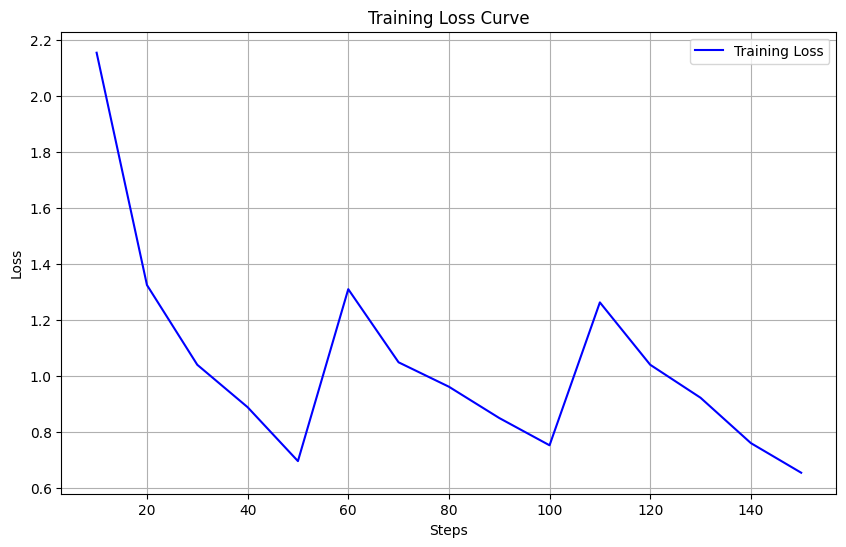

In [10]:
# Visualize Training Loss
history = trainer.state.log_history
steps = []
losses = []

for entry in history:
    if 'loss' in entry:
        steps.append(entry['step'])
        losses.append(entry['loss'])

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label='Training Loss', color='blue')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## 9. Save, Model Card & Push

In [11]:
# Create Model Card (README.md)
model_card_content = f"""
---
base_model: {CONFIG['model_id']}
library_name: peft
license: mit
tags:
- finance
- llama-3
- 4-bit
- loRA
---

# {CONFIG['new_model_name']}

This model is a fine-tuned version of **{CONFIG['model_id']}** on the **Uber 2024 Annual Report** dataset.
It is designed to act as a financial analyst "Intern", capable of answering questions with the specific strategy and tone of the source document.

## Model Details
- **Base Model:** {CONFIG['model_id']}
- **Architecture:** 4-bit Quantization (NF4) + LoRA Adapters
- **Task:** Financial Question Answering

## Training Configuration
- **LoRA Rank:** {CONFIG['lora_r']}
- **LoRA Alpha:** {CONFIG['lora_alpha']}
- **Batch Size:** {CONFIG['batch_size']}
- **Learning Rate:** {CONFIG['learning_rate']}
- **Epochs:** {CONFIG['num_epochs']}

## Usage
```python
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, PeftConfig

base_model_id = "{CONFIG['model_id']}"
adapter_model_id = "{CONFIG['hf_username']}/{CONFIG['new_model_name']}"

# Load Base Model
base_model = AutoModelForCausalLM.from_pretrained(base_model_id)
# Load Adapter
model = PeftModel.from_pretrained(base_model, adapter_model_id)
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

input_text = "What is the company's strategy for 2024?"
inputs = tokenizer(input_text, return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0]))
```
"""

# Ensure directory exists
os.makedirs(CONFIG['new_model_name'], exist_ok=True)

with open(f"{CONFIG['new_model_name']}/README.md", "w") as f:
    f.write(model_card_content)

print(f"Model Card saved to {CONFIG['new_model_name']}/README.md")

Model Card saved to Llama-3-8b-Financial-Intern/README.md


In [15]:
new_model = CONFIG["new_model_name"]
trainer.model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)
if CONFIG.get("push_to_hub", False):
    repo_name = f"{CONFIG['hf_username']}/{CONFIG['new_model_name']}"

    print(f"\n Pushing to Hugging Face Hub: {repo_name}")

    # Using Unsloth's optimized push method
    model.push_to_hub(repo_name)
    tokenizer.push_to_hub(repo_name)

    print(f" Pushed to Hub: https://huggingface.co/{repo_name}")
else:
    print("\n Hub upload skipped (push_to_hub=False)")


 Hub upload skipped (push_to_hub=False)


## 10. Extended Evaluation (Golden Test Set)
Evaluating on the `golden_test_set.jsonl` and saving detailed results.

In [21]:
def query_intern(question, model_to_use, tokenizer_to_use):
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

YouYou are a financial analyst specializing in the 2024 Annual Report. Answer strictly based on context.<|eot_id|><|start_header_id|>user<|end_header_id|>

{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

    inputs = tokenizer_to_use(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model_to_use.generate(
            **inputs,
            max_new_tokens=128,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer_to_use.eos_token_id
        )

    response = tokenizer_to_use.decode(outputs[0], skip_special_tokens=True)
    return response.split("assistant")[-1].strip()

# Load Golden Test Set
test_dataset = load_dataset("json", data_files=r"/content/golden_test_set.jsonl", split="train")
print(f"Loaded {len(test_dataset)} test examples.")

# Evaluate on a subset (e.g., first 10 for demonstration, or all)
results = []
print("Running evaluation...")

# Clear GPU memory from fine-tuning if trainer and model exist
if 'trainer' in globals():
    del trainer
if 'model' in globals():
    del model # Delete the fine-tuned model reference
gc.collect()
torch.cuda.empty_cache()
print("GPU memory cleared before loading base model.")

# Load Base Model for comparison
# Re-load the fine-tuned model for inference after the base model,
# or keep it in memory if there's enough space (which might not be the case).
# For now, we will assume we can load it back later if needed, or query it after base model is done.
# However, for direct comparison, we will need to load it again or ensure it's still available.
# Let's re-instantiate it from the saved adapter weights.

#  use the already loaded `trainer.model` which is the PeftModel.
# However, it was deleted above. Let's rethink.

# The most robust way to compare is to free up memory, then load base model, test it, free memory.
# Then load the fine-tuned model, test it, and free memory. This avoids OOM.

# Let's perform the evaluation iteratively to prevent OOM

all_results = []

# Evaluate Base Model
print("Evaluating Base Model...")
base_model = AutoModelForCausalLM.from_pretrained(
    CONFIG["model_id"],
    quantization_config=bnb_config,
    device_map="auto",
    use_cache=True
)

for i, sample in enumerate(test_dataset):
    if i >= 10: break  # Limit for demo
    question = sample['question']
    ground_truth = sample['answer']
    base_pred = query_intern(question, base_model, tokenizer)
    all_results.append({"question": question, "ground_truth": ground_truth, "base_model": base_pred, "fine_tuned": None}) # Fine-tuned will be added later

del base_model
gc.collect()
torch.cuda.empty_cache()
print("Base Model evaluation complete. GPU memory cleared.")

# Evaluate Fine-Tuned Model (re-load if necessary, or use the one from trainer if it's still available)
# Since `trainer` and `model` were deleted, we need to load the saved fine-tuned adapter on top of the base model.
print("Evaluating Fine-Tuned Model...")

# Reload the base model (quantized) first
base_model_for_tuned_inference = AutoModelForCausalLM.from_pretrained(
    CONFIG["model_id"],
    quantization_config=bnb_config,
    device_map="auto",
    use_cache=True
)

# Load the PEFT adapter
fine_tuned_model_path = CONFIG['new_model_name'] # This should point to the directory where the adapter was saved
fine_tuned_model = PeftModel.from_pretrained(base_model_for_tuned_inference, fine_tuned_model_path)

for i, sample in enumerate(test_dataset):
    if i >= 10: break  # Limit for demo
    question = sample['question']
    tuned_pred = query_intern(question, fine_tuned_model, tokenizer)
    all_results[i]["fine_tuned"] = tuned_pred # Update the existing entry

del fine_tuned_model
del base_model_for_tuned_inference
gc.collect()
torch.cuda.empty_cache()
print("Fine-Tuned Model evaluation complete. GPU memory cleared.")

# Print Comparison
import pandas as pd
df_results = pd.DataFrame(all_results)
pd.set_option('display.max_colwidth', None)

print("\n--- Visual Comparison (Top 5) ---")
display(df_results.head(5)) # Use display() in Jupyter, or print() otherwise

Loaded 600 test examples.
Running evaluation...
GPU memory cleared before loading base model.
Evaluating Base Model...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Base Model evaluation complete. GPU memory cleared.
Evaluating Fine-Tuned Model...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Fine-Tuned Model evaluation complete. GPU memory cleared.

--- Visual Comparison (Top 5) ---


,question,ground_truth,base_model,fine_tuned
0,How does the tone of the text reflect the company's outlook on growth and expenses?,"The tone of the text reflects a positive outlook on growth, indicating that general and administrative expenses are expected to increase in absolute terms due to business growth and increased trip volume. However, it also conveys optimism regarding efficiency improvements, suggesting that these expenses will decrease as a percentage of revenue over time. This dual perspective highlights a focus on both growth and operational efficiency.","I'd be happy to help you analyze the tone of the text. However, I don't see a text provided. Could you please share the text from the 2024 Annual Report, and I'll do my best to assess the tone and provide an analysis of the company's outlook on growth and expenses?",Information not found in context.
1,What types of legislative proposals are currently being considered that could affect the business model?,Information not found in context.,"As a financial analyst specializing in the 2024 Annual Report, I've been tracking several legislative proposals that could potentially impact our business model. Here are some key ones:\n\n1. **Tax Reform**: The proposed Tax Cuts and Jobs Act 2.0 aims to modify the corporate tax rate, potentially affecting our tax liability and cash flow. If passed, this could lead to a reduction in our tax expenses, but also might impact our ability to deduct certain expenses.\n2. **Climate Change and Sustainability Regulations**: The proposed Climate Action Now Act seeks to impose stricter emissions standards and carbon pricing mechanisms. This could lead to increased costs associated",Information not found in context.
2,"What strategic goal can be inferred from the significant increase in net income from 1,887 million to 9,856 million?",Information not found in context.,"Based on the significant increase in net income from 1,887 million to 9,856 million, a strategic goal that can be inferred is:\n\n**Expansion and Diversification**\n\nThis substantial increase in net income suggests that the company has successfully executed its growth strategy, likely through a combination of organic growth, strategic acquisitions, and/or innovative business initiatives. The company may have expanded its customer base, diversified its revenue streams, or entered new markets, leading to a significant boost in revenue and profitability.\n\nAdditionally, this growth may also indicate that the company has:\n\n1. **Improved operational efficiency**: The company may have optimized its processes,",Information not found in context.
3,What tone is used when discussing the potential for adverse publicity or fines?,The tone used when discussing the potential for adverse publicity or fines is cautionary and serious.,"When discussing the potential for adverse publicity or fines in the 2024 Annual Report, the tone is typically cautious, objective, and risk-averse. The language used is formal and professional, with a focus on transparency and disclosure.\n\nThe report may use phrases such as:\n\n* ""We are subject to various risks and uncertainties that could result in adverse publicity or fines, including...""\n* ""The Company may be subject to regulatory scrutiny and potential fines if we fail to comply with applicable laws and regulations...""\n* ""We have identified potential risks related to adverse publicity, including...""\n* ""The Company has implemented policies and procedures to mitigate the risk of",Information not found in context.
4,What could be the potential consequences for the business if platform users stop using the platform due to authentication requirements?,"If platform users stop using the platform due to authentication requirements, it could adversely affect the business, financial condition, operating results, and prospects. Additionally, an increase in Driver payments without corresponding payments from consumers could further negatively impact th

In [22]:
# Save Results
os.makedirs("../results", exist_ok=True)
df_results.to_json("../results/finetuned_results.jsonl", orient="records", lines=True)
print("\nResults saved to ../results/finetuned_results.jsonl")


Results saved to ../results/finetuned_results.jsonl


In [24]:
print("Completed")

Completed
